In [1]:
import os
import sys
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

In [2]:
radius = 500

In [3]:
temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']
temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
temp = temp[temp['data_type'] == 'observed']
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

In [32]:
# train on heat island summer evening nights
hid = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/heat_island_dates.csv')

In [33]:
hid['datetime_UTC'] = pd.to_datetime(hid['datetime_UTC'])

In [34]:
# select may, june, july evenings
hid = hid[(hid['datetime_UTC'].dt.month >= 5) & (hid['datetime_UTC'].dt.month <= 7)]

In [35]:
hid = hid[(hid['datetime_UTC'].dt.hour.isin([20, 21, 22, 23, 0, 1]))]

In [37]:
#check if 27th june is in list

hid[(hid['datetime_UTC'].dt.month == 6) & (hid['datetime_UTC'].dt.day == 27)]

,datetime_UTC
445,2023-06-27 23:00:00+00:00


In [186]:
# train on weather station data

vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF_3D']
vars = vars.drop(to_remove, axis=1)
vars = vars.merge(temp, left_on='station_id', right_on='station_id',how='inner')

In [187]:
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

In [188]:
training_data = vars[params+['2023-06-27 20:00:00+00:00']].dropna()

In [193]:
training_data

,BuAre_sum,BuVol_3D_sum,BuEWA_3D_sum,BuIBD,BuAdj,BuSWR_3D_median,BuHt_wmean,StrHW_median,SVF_3D_mean,BuSqC_wmean,BuFra_3D_wmean,StrClo400_median,2023-06-27 20:00:00+00:00
station_id,,,,,,,,,,,,,
FRASHA,108729.200187,1.384604e+06,4.239708e+05,22.611718,0.514957,0.183756,12.796734,0.429424,0.882380,0.750035,0.258766,0.000009,-1.007711
FRBETZ,98598.966471,1.351474e+06,4.115861e+05,24.490266,0.473808,0.152278,13.747844,0.391595,0.853384,0.718214,0.259001,0.000010,0.249547
FRBRUH,195768.896366,1.933189e+06,4.399746e+05,33.109868,0.693182,0.024770,9.904234,0.267609,0.878348,0.703753,0.252986,0.000002,0.347515
FRDREI,119431.841981,1.368402e+06,4.481072e+05,23.682102,0.457249,0.126110,11.498565,0.401413,0.833965,0.801517,0.266842,0.000005,0.404663
FRFRIE,79115.602275,1.052894e+06,3.156499e+05,48.147899,0.659443,0.038368,13.347875,0.422664,0.943977,0.597692,0.246079,0.000003,0.331187
FRGART,148933.766685,1.602179e+06,5.415276e+05,20.550857,0.250000,0.392322,10.242493,0.406372,0.833574,0.700695,0.259152,0.000009,0.192399
FRGLBA,82600.984786,8.724311e+05,3.555287e+05,23.080961,0.707692,0.064672,10.600493,0.370214,0.875029,0.805419,0.274953,0.000004,-3.114026
FRGUNT,48125.489056,4.596546e+05,2.034206e+05,29.514664,0.767516,0.030859,9.587418,0.324986,0.926669,0.789353,0.277856,0.000004,-2.354773
FRHAID,104878.331592,1.045322e+06,2.777336e+05,35.814039,0.737374,0.015358,10.003556,0.277137,0.943898,0.745441,0.256510,0.000003,0.437319


In [169]:
training_data['2023-06-27 20:00:00+00:00'] = training_data['2023-06-27 20:00:00+00:00'] - 22.2

In [190]:
scaler = StandardScaler()
temp_scaled = scaler.fit_transform(training_data[['2023-06-27 20:00:00+00:00']])
training_data['2023-06-27 20:00:00+00:00'] = temp_scaled

In [192]:
# perform multiple linear regression on training data
X = training_data[params]
y = training_data['2023-06-27 20:00:00+00:00']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                                OLS Regression Results                               
Dep. Variable:     2023-06-27 20:00:00+00:00   R-squared:                       0.603
Model:                                   OLS   Adj. R-squared:                  0.322
Method:                        Least Squares   F-statistic:                     2.149
Date:                       Thu, 20 Mar 2025   Prob (F-statistic):             0.0729
Time:                               15:36:02   Log-Likelihood:                -28.724
No. Observations:                         30   AIC:                             83.45
Df Residuals:                             17   BIC:                             101.7
Df Model:                                 12                                         
Covariance Type:                   nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [173]:
# Testing on meteobike data

stn_buffers = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_processed_station_params_' + str(radius) + '.parquet')

In [154]:
stn_buffers['Werthmann'] = stn_buffers['Absolute_temperature_degC'] - stn_buffers['Temperature_diff_K']

In [174]:
mbike = stn_buffers[params+['Temperature_diff_K']].dropna()

In [175]:
mbike

,BuAre_sum,BuVol_3D_sum,BuEWA_3D_sum,BuIBD,BuAdj,BuSWR_3D_median,BuHt_wmean,StrHW_median,SVF_3D_mean,BuSqC_wmean,BuFra_3D_wmean,StrClo400_median,Temperature_diff_K
0,269374.139852,4.155824e+06,1.037027e+06,14.417447,0.339000,0.263982,15.481492,0.755851,0.710335,0.703219,0.250941,0.000019,1.30
1,264803.819232,4.084409e+06,1.030339e+06,14.708512,0.354677,0.244733,15.478184,0.755851,0.707870,0.711192,0.251114,0.000019,1.10
2,253538.420631,3.829748e+06,1.008722e+06,15.036962,0.377997,0.225117,15.158501,0.708960,0.708557,0.717197,0.253326,0.000017,1.02
3,252121.149708,3.815363e+06,1.004493e+06,15.032734,0.378583,0.224527,15.186486,0.711497,0.708243,0.716748,0.253192,0.000017,1.02
4,227715.775169,3.294937e+06,9.277479e+05,15.851557,0.416802,0.198322,14.521820,0.605304,0.726368,0.722128,0.255542,0.000013,1.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5936,273261.666840,4.213814e+06,1.061645e+06,14.515208,0.346146,0.254649,15.474087,0.764852,0.706138,0.702646,0.251045,0.000019,-0.75
5937,275672.203826,4.244198e+06,1.065245e+06,14.463126,0.343112,0.259443,15.449326,0.764852,0.706639,0.701934,0.250975,0.000019,-0.54
5938,274336.284796,4.221927e+06,1.057694e+06,14.332108,0.336449,0.265449,15.443134,0.768439,0.707116,0.701095,0.251097,0.000019,-0.44
5939,273220.573787,4.211426e+06,1.054050e+06,14.298122,0.333561,0.266908,15.467656,0.772362,0.708499,0.699520,0.251029,0.000019,-0.44


In [176]:
mbike_scaled = scaler.fit_transform(mbike[['Temperature_diff_K']])
mbike['Temperature_diff_K'] = mbike_scaled

In [177]:
mbike

,BuAre_sum,BuVol_3D_sum,BuEWA_3D_sum,BuIBD,BuAdj,BuSWR_3D_median,BuHt_wmean,StrHW_median,SVF_3D_mean,BuSqC_wmean,BuFra_3D_wmean,StrClo400_median,Temperature_diff_K
0,269374.139852,4.155824e+06,1.037027e+06,14.417447,0.339000,0.263982,15.481492,0.755851,0.710335,0.703219,0.250941,0.000019,1.346210
1,264803.819232,4.084409e+06,1.030339e+06,14.708512,0.354677,0.244733,15.478184,0.755851,0.707870,0.711192,0.251114,0.000019,1.227373
2,253538.420631,3.829748e+06,1.008722e+06,15.036962,0.377997,0.225117,15.158501,0.708960,0.708557,0.717197,0.253326,0.000017,1.179838
3,252121.149708,3.815363e+06,1.004493e+06,15.032734,0.378583,0.224527,15.186486,0.711497,0.708243,0.716748,0.253192,0.000017,1.179838
4,227715.775169,3.294937e+06,9.277479e+05,15.851557,0.416802,0.198322,14.521820,0.605304,0.726368,0.722128,0.255542,0.000013,1.179838
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5936,273261.666840,4.213814e+06,1.061645e+06,14.515208,0.346146,0.254649,15.474087,0.764852,0.706138,0.702646,0.251045,0.000019,0.128133
5937,275672.203826,4.244198e+06,1.065245e+06,14.463126,0.343112,0.259443,15.449326,0.764852,0.706639,0.701934,0.250975,0.000019,0.252912
5938,274336.284796,4.221927e+06,1.057694e+06,14.332108,0.336449,0.265449,15.443134,0.768439,0.707116,0.701095,0.251097,0.000019,0.312330
5939,273220.573787,4.211426e+06,1.054050e+06,14.298122,0.333561,0.266908,15.467656,0.772362,0.708499,0.699520,0.251029,0.000019,0.312330


In [178]:
mbike['Temperature_diff_K'].min()

-3.3359589027382657

In [181]:
X_test = mbike[params]
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

In [182]:
y_test = mbike['Temperature_diff_K']

In [183]:
(y_test - y_pred)**2

0       1.027390
1       0.746063
2       0.630141
3       0.659280
4       0.871325
          ...   
5936    0.061101
5937    0.017065
5938    0.004532
5939    0.002347
5940    0.000031
Length: 5346, dtype: float64

In [184]:
y_pred.isna().value_counts()

False    5346
Name: count, dtype: int64

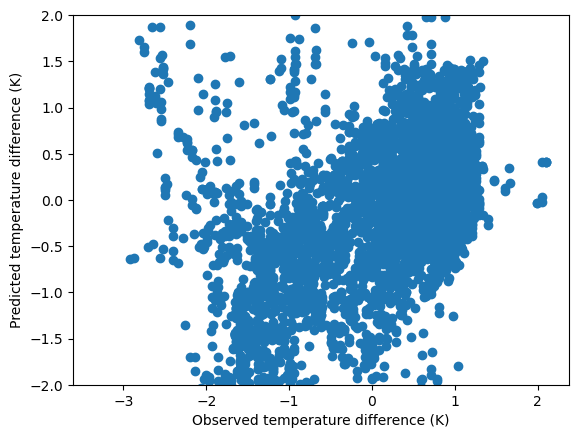

In [198]:
# plot results
fig = plt.figure()
plt.xlabel('Observed temperature difference (K)')
plt.ylabel('Predicted temperature difference (K)')
plt.ylim(-2, 2)
plt.scatter(y_test, y_pred)

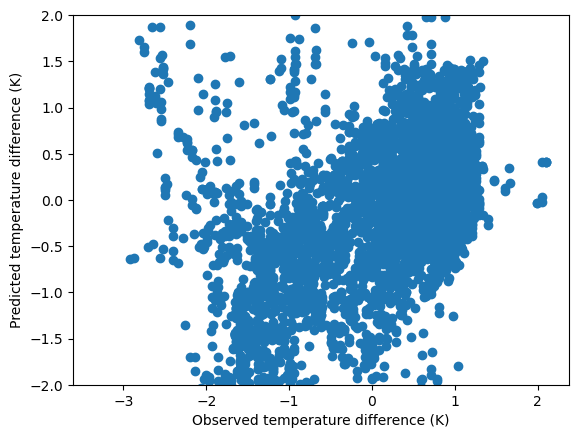

In [134]:
# plot results
fig = plt.figure()
plt.xlabel('Observed temperature difference (K)')
plt.ylabel('Predicted temperature difference (K)')
plt.ylim(-2, 2)
plt.scatter(y_test, y_pred)

In [197]:
pd.DataFrame({'observed': y_test, 'predicted': y_pred})

,observed,predicted
0,1.346210,0.332607
1,1.227373,0.363624
2,1.179838,0.386024
3,1.179838,0.367878
4,1.179838,0.246391
...,...,...
5936,0.128133,0.375319
5937,0.252912,0.383544
5938,0.312330,0.379649
5939,0.312330,0.360777


In [194]:
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)


In [195]:
r2

-3.159777657866943

In [ ]:
y_pred = model.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)

In [ ]:
data = vars[[var] + list(hiwn.values.flatten())].copy().reset_index()
data = data.melt(id_vars=[var,'station_id'], value_vars=hiwn.values.flatten(), var_name='time', value_name='temperature')
data = data.dropna()

Swap testing and training

In [199]:
# perform multiple linear regression on training data
X = mbike[params]
y = mbike['Temperature_diff_K']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     Temperature_diff_K   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     823.0
Date:                Thu, 20 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:10:41   Log-Likelihood:                -4784.3
No. Observations:                5346   AIC:                             9595.
Df Residuals:                    5333   BIC:                             9680.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.5654      0.676  

In [202]:
X_test = training_data[params]
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

In [203]:
y_pred

station_id
FRASHA   -0.042956
FRBETZ    0.117094
FRBRUH    1.475176
FRDREI    0.437181
FRFRIE   -0.134540
FRGART    0.928637
FRGLBA   -0.515494
FRGUNT   -0.982097
FRHAID   -0.121979
FRHBHF    1.006251
FRHERD    0.655330
FRHOLZ    1.022108
FRIHOC    0.266069
FRINST    0.890236
FRKART    1.282211
FRLAND   -0.408536
FRLORE   -0.228634
FRMESS    0.369281
FROWIE    0.725399
FRPDAS    1.208239
FRRIES    0.451944
FRSTGA    0.599353
FRSTGE   -0.001634
FRSTUH    0.862189
FRUNIK    0.692165
FRUWIE    0.829049
FRVAUB    0.776906
FRWEIN    0.589749
FRWSEE   -0.178150
FRZAHR   -0.663156
dtype: float64

In [210]:
y_test = training_data['2023-06-27 20:00:00+00:00']

In [211]:
y_test

station_id
FRASHA   -1.007711
FRBETZ    0.249547
FRBRUH    0.347515
FRDREI    0.404663
FRFRIE    0.331187
FRGART    0.192399
FRGLBA   -3.114026
FRGUNT   -2.354773
FRHAID    0.437319
FRHBHF    0.380171
FRHERD    0.012790
FRHOLZ    0.143414
FRIHOC   -0.379082
FRINST    0.886339
FRKART    1.637428
FRLAND    0.029118
FRLORE   -1.228139
FRMESS    0.535287
FROWIE    0.102594
FRPDAS    0.918995
FRRIES    0.992471
FRSTGA   -0.705643
FRSTGE    0.845519
FRSTUH    1.147588
FRUNIK    0.886339
FRUWIE    0.094430
FRVAUB    0.200563
FRWEIN    0.110758
FRWSEE   -1.236303
FRZAHR   -0.860759
Name: 2023-06-27 20:00:00+00:00, dtype: float64

Text(0, 0.5, 'Observed temperature difference (K)')

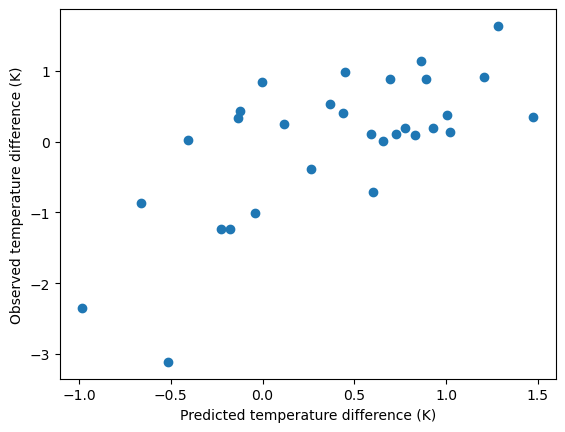

In [207]:
plt.scatter(y_pred,training_data['2023-06-27 20:00:00+00:00'])
plt.xlabel('Predicted temperature difference (K)')
plt.ylabel('Observed temperature difference (K)')

In [212]:
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)

In [213]:
r2

0.30565464762887884